- Importamos librerías:

In [2]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import pygame

- Creamos el entorno y visualizamos los valores de los límites inferiores y superiores del entorno:

In [3]:
env = gym.make("CartPole-v1", render_mode="human")

In [4]:
print("Límites superiores:", env.observation_space.high)	
print("Límites inferiores:", env.observation_space.low)	
print("Número de acciones disponibles:", env.action_space.n)           

Límites superiores: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Límites inferiores: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Número de acciones disponibles: 2


# ALGORITMO SARSA

- Definimos los hiperparámetros:

In [5]:
episodes = 1000
discount = 0.95
episodes_display = 10
learning_rate = 0.25
epsilon = 0.2

In [6]:
theta_minmax = env.observation_space.high[2] #se accede al tercer elemento del sistema (ángulo del poste)
theta_dot_minmax = math.radians(50) #convertimos el valor de grados a radianes para asegurarnos que este en la misma
                                    #escala que la observación del entorno

theta_state_size = 50 #dividimos el rango de ángulos que puede tomar el poste en 50 partes iguales
theta_dot_state_size = 50 #lo mismo para la velocidad

#Inicializamos la tabla Q con valores aleatorios
q_table = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)

In [7]:
#Lista para almacenar las recompensas totales:
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

In [16]:
for episode in range(episodes):
    episode_reward = 0  # rastrea recompensa total obtenida en cada episodio
    done = False

    if episode % episodes_display == 0:
        render_state = True  # para mostrar o no el estado del entorno
    else:
        render_state = False

    state_array = env.reset()[0]
    curr_discrete_state = discretised_state(state_array)  # asigna a la variable el estado inicial del
    # entorno discretizado

    # a continuación, si el número aleatorio generado es mayor que epsilon,
    # el agente seleccionará la acción con el valor más alto de Q,
    # si no, seleccionará una acción aleatoria:
    if np.random.random() > epsilon:
        action = np.argmax(q_table[curr_discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)

    while not done:
        new_state, reward, done, _, _ = env.step(action)
        new_discrete_state = discretised_state(new_state)  # se discretiza para obtener el nuevo estado del entorno

        if np.random.random() > epsilon:
            new_action = np.argmax(q_table[new_discrete_state])
        else:
            new_action = np.random.randint(0, env.action_space.n)

        if render_state:
            env.render()

        if not done:
            current_q = q_table[curr_discrete_state + (action,)]  # valor Q actual asociado con el
            # par estado-acción actual
            max_future_q = q_table[new_discrete_state + (new_action,)]  # obtiene valor Q máximo esperado
            # para los próximos estado y acción
            new_q = current_q + learning_rate * (
                        reward + discount * max_future_q - current_q)  # calcula el nuevo valor Q
            # para el par estado-acción actual
            q_table[curr_discrete_state + (action,)] = new_q

        curr_discrete_state = new_discrete_state
        action = new_action

        episode_reward += reward

    ep_rewards.append(episode_reward)

    if not episode % episodes_display:
        avg_reward = sum(ep_rewards[-episodes_display:]) / len(ep_rewards[-episodes_display:])
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-episodes_display:]))
        ep_rewards_table['max'].append(max(ep_rewards[-episodes_display:]))
        print(
            f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-episodes_display:])} max:{max(ep_rewards[-episodes_display:])}")

env.close()


Episode:0 avg:15.0 min:15.0 max:15.0
Episode:10 avg:31.3 min:13.0 max:51.0
Episode:20 avg:29.6 min:12.0 max:60.0
Episode:30 avg:31.5 min:16.0 max:77.0
Episode:40 avg:19.8 min:8.0 max:33.0
Episode:50 avg:32.0 min:12.0 max:46.0
Episode:60 avg:22.1 min:10.0 max:56.0
Episode:70 avg:29.6 min:12.0 max:101.0
Episode:80 avg:26.1 min:14.0 max:45.0
Episode:90 avg:31.9 min:13.0 max:76.0
Episode:100 avg:19.9 min:9.0 max:51.0
Episode:110 avg:37.0 min:10.0 max:60.0
Episode:120 avg:20.7 min:11.0 max:38.0
Episode:130 avg:25.4 min:11.0 max:51.0
Episode:140 avg:24.8 min:11.0 max:69.0
Episode:150 avg:20.8 min:9.0 max:37.0
Episode:160 avg:20.1 min:11.0 max:33.0
Episode:170 avg:21.6 min:13.0 max:54.0
Episode:180 avg:21.0 min:11.0 max:38.0
Episode:190 avg:25.2 min:11.0 max:46.0
Episode:200 avg:23.2 min:9.0 max:49.0
Episode:210 avg:21.0 min:11.0 max:43.0
Episode:220 avg:22.1 min:9.0 max:46.0
Episode:230 avg:33.3 min:11.0 max:62.0
Episode:240 avg:26.4 min:10.0 max:68.0
Episode:250 avg:18.8 min:10.0 max:38.0
E

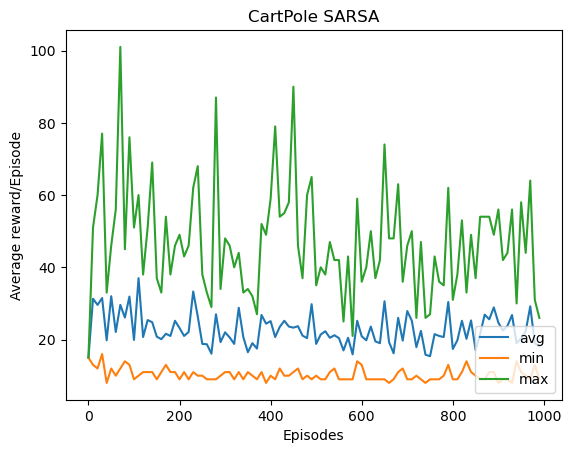

In [17]:
#Representamos en gráfico
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('CartPole SARSA')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

## Métricas

**1. Media móvil** <p>
Ya que las recompensas pueden variar mucho de un episodio a otro, calcularemos la media móvil. Esto significa calcular el promedio de recompensas de x número de episodios consecutivos y así ver mejor si realmente el agente ha mejorado. Vamos a coger una ventana de 100 episodios y así ver si recientemente ha habido mejoría.

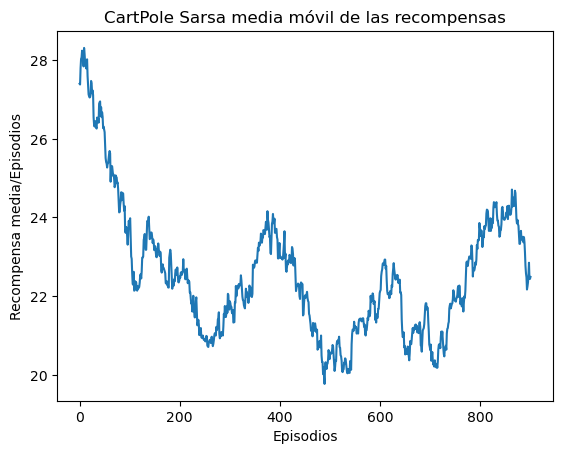

In [18]:
window_size = 100
moving_avg_rewards = np.convolve(ep_rewards, np.ones(window_size)/window_size, mode='valid')

# Graficar la recompensa promedio móvil
plt.plot(np.arange(len(moving_avg_rewards)), moving_avg_rewards)
plt.title('CartPole Sarsa media móvil de las recompensas')
plt.ylabel('Recompensa media/Episodios')
plt.xlabel('Episodios')
plt.show()

**2. Tasa de convergencia** <p>
Representa la diferencia entre la recompensa promedio al final del entrenamiento y al principio entre el número total de episodios. Esto sirve para descubrir qué tan rápido está mejorando el desempeño del agente a lo largo del tiempo. 

In [10]:
# Calculate the convergence rate
convergence_rate = (ep_rewards_table['avg'][-1] - ep_rewards_table['avg'][0]) / len(ep_rewards_table['avg'])
print("Tasa de convergencia:", convergence_rate)

Tasa de convergencia: 0.10600000000000001
